In [1]:
field=['Lockman-SWIRE']
path_to_SPIRE=['/Volumes/pdh_storage/dmu_products/dmu19/dmu19_HELP-SPIRE-maps/data/']
#path_to_SPIRE=['/mnt/lustre/users/astro/pdh21/Extreme_submm_SB_gals/data/']
redshift_file=["/Volumes/pdh_storage/dmu_products/dmu24/dmu24_Lockman-SWIRE/data/master_catalogue_Lockman-SWIRE_20170710_photoz_20170802_r_and_irac1_optimised_UPDATED_IDs_20180219.fits"]
#redshift_file=["/mnt/lustre/users/astro/pdh21/Extreme_submm_SB_gals/data/master_catalogue_Lockman-SWIRE_20170710_photoz_20170802_r_and_irac1_optimised_UPDATED_IDs_20180219.fits"]

In [2]:
from astropy.io import ascii, fits
from astropy.table import Table
import pylab as plt
%matplotlib inline
from astropy import wcs
import seaborn as sns
import glob
import arviz as az

import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import os
from ESB_functions import *
sns.set_context("paper")

/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [3]:
try:
    source = [np.int(os.environ['SGE_TASK_ID'])-1]
except:
    source=[1]

In [4]:
esb=Table.read('../../../data/MRR2018_tables/{}_sources.csv'.format(field[0]),format='ascii',encoding='utf-8')

In [5]:
data=az.InferenceData.from_netcdf('./output/{}/posterior_{}_{}_{}.nc'.format(field[0],field[0],source[0],'model2'))
prior_list=Table.read('./output/{}/prior_list_{}_{}_{}.ascii'.format(field[0],field[0],source[0],'model2'),format='ascii',encoding='utf-8')
priors,_ = xidplus.load('./output/{}/prior_{}_{}_{}.pkl'.format(field[0],field[0],source[0],'model2'))

In [6]:
from astropy.coordinates import SkyCoord
from astropy import units as u
import os

c = SkyCoord(ra=[esb['RA'][source[0]]]*u.degree, dec=[esb['Dec'][source[0]]]*u.degree)

In [7]:
#find the sources that are within a certain separation of the extreme starburst candidate
sep=12
separation=c.separation(SkyCoord(priors[0].sra,priors[0].sdec)).arcsec
contrib_sources=separation<sep
print(' Sources \n {} \n are possible contributers to flux of extreme starburst'.format(priors[0].ID[contrib_sources]))

 Sources 
           help_id          
---------------------------
HELP_J104201.994+584018.387
HELP_J104201.199+584021.132
HELP_J104201.658+584011.825
HELP_J104200.887+584011.215
HELP_J104201.712+584006.945
HELP_J104202.499+584025.262 
 are possible contributers to flux of extreme starburst


In [8]:
ind = prior_list['help_id']==priors[0].ID[np.argmin(separation)]


In [9]:
import jax.numpy as jnp
emulator_path=['/Users/pdh21/Google_Drive/WORK/XID_plus/docs/notebooks/examples/SED_emulator/CIGALE_emulator_20210420_log10sfr_uniformAGN_z.npz']


def create_phys_prior(priors,prior_list,emulator_path):
    z_mu=np.empty((priors[1].nsrc))
    z_sig=np.empty((priors[1].nsrc))

    for x,i in enumerate(priors[1].ID):
        
        ind=prior_list['help_id']==str(i)
        z_mu[x]=prior_list['redshift'][ind]
        z_sig[x]=prior_list['redshift_unc'][ind]

    

    sfr_mu=1.5*z_mu+1.0
    sfr_sig=np.full(priors[1].nsrc,0.5)

    agn_frac_mu=np.full(priors[1].nsrc,-1)
    agn_frac_sig=np.full(priors[1].nsrc,1)
    params_mu=np.vstack((sfr_mu,z_mu)).T
    params_sig=np.vstack((sfr_sig,z_sig)).T
    params_names=['log10sfr','z']
    
    return xidplus.hier_prior(priors[1].ID,params_mu,params_sig,params_names,emulator_path[0])

hier_params={'m_mu':0.8,'m_sig':0.4,'c_mu':-1.0,'c_sig':0.5,'sfr_disp':0.5}
phys_prior=create_phys_prior(priors,prior_list,emulator_path)


#stack params and make vector ready to be used by emualator
params = jnp.stack((data.posterior.sfr.values.reshape(data.posterior.chain.size * data.posterior.draw.size,data.posterior.src.size).T, data.posterior.agn.values.reshape(data.posterior.chain.size * data.posterior.draw.size,data.posterior.src.size).T,data.posterior.redshift.values.reshape(data.posterior.chain.size * data.posterior.draw.size,data.posterior.src.size).T)).T
# Use emulator to get fluxes. As emulator provides log flux, convert.
src_f = np.array(jnp.exp(phys_prior.emulator['net_apply'](phys_prior.emulator['params'], params)))


#stack params and make vector ready to be used by emualator
params_prior = jnp.stack((data.prior.sfr.values.reshape(data.prior.chain.size * data.prior.draw.size,data.prior.src.size).T, data.prior.agn.values.reshape(data.prior.chain.size * data.prior.draw.size,data.prior.src.size).T,data.prior.redshift.values.reshape(data.prior.chain.size * data.prior.draw.size,data.prior.src.size).T)).T

# Use emulator to get fluxes. As emulator provides log flux, convert.
src_f_prior = np.array(jnp.exp(phys_prior.emulator['net_apply'](phys_prior.emulator['params'], params_prior)))

W0527 15:29:50.692551 4577742272 xla_bridge.py:135] No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [10]:
nsamp=60

In [11]:
w,f=getSEDs(data,np.argmin(separation), nsamp=nsamp)

In [12]:
w_prior,f_prior=getSEDs(data,np.argmin(separation), nsamp=nsamp,category='prior')

In [13]:
import herschelhelp

In [14]:
filters=[]
for c in prior_list.colnames:
    if 'f_' in c:
        filt=c.split('f_')[1]
        try:
            if not prior_list[ind]['f_'+filt].mask and ('ap' not in filt):
                filters.append(filt)
        except KeyError:
            pass


In [15]:
wavelength=np.array([herschelhelp.database.get_filters(f).mean_wavelength/1.0E4 for f in filters])
flux=np.array([prior_list[ind]['f_'+f].data/1.E3 for f in filters])
flux_error=np.array([prior_list[ind]['ferr_'+f].data/1.E3 for f in filters])

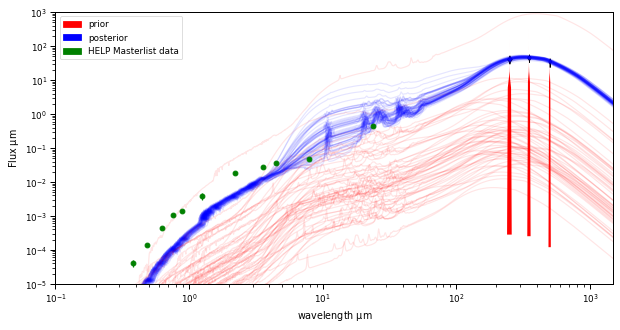

In [27]:
plt.figure(figsize=(10,5))
for i in range(0,nsamp):
    plt.loglog(w['wavelength_{}'.format(i+1)],f['Fnu_{}'.format(i+1)],'b',alpha=0.1)
    plt.loglog(w_prior['wavelength_{}'.format(i+1)],f_prior['Fnu_{}'.format(i+1)],'r',alpha=0.1)


    plt.xlim(0.1,1.5E3)
v=plt.violinplot(src_f[:,np.argmin(separation),:],positions=np.array([250,350,500]),showextrema=False,widths=20)
for pc in v['bodies']:
        pc.set_facecolor('blue')
        pc.set_edgecolor('black')
        pc.set_alpha(1.0)
v=plt.violinplot(src_f_prior[:,np.argmin(separation),:],positions=np.array([250,350,500]),showextrema=False,widths=20)
for pc in v['bodies']:
        pc.set_facecolor('red')
        pc.set_alpha(1.0)
plt.ylim(1E-5,1E3)
w_ind=wavelength<100
plt.errorbar(wavelength[w_ind],flux[w_ind],yerr=flux_error.reshape(-1)[w_ind],fmt='go',label='HELP masterlist')
plt.xlabel('wavelength $\mathrm{\mu m}$')
plt.ylabel('Flux $\mathrm{\mu m}$')

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red')
blue_patch = mpatches.Patch(color='blue')
green_patch = mpatches.Circle(0,color='green')

plt.legend([red_patch,blue_patch,green_patch],['prior','posterior','HELP Masterlist data'])

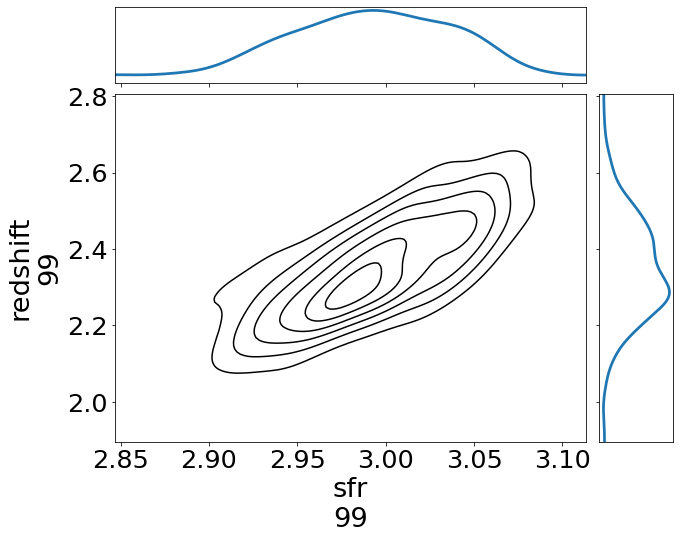

In [30]:
coords = {"src": [np.argmin(separation)]}
ax = az.plot_pair(
    data,
    var_names=["sfr", "redshift"],
    kind=["scatter", "kde"],
    kde_kwargs={"fill_last": False},
    marginals=True,
    coords=coords,
    figsize=(10, 8),
)


array([[<AxesSubplot:title={'center':'m'}>,
        <AxesSubplot:title={'center':'m'}>]], dtype=object)

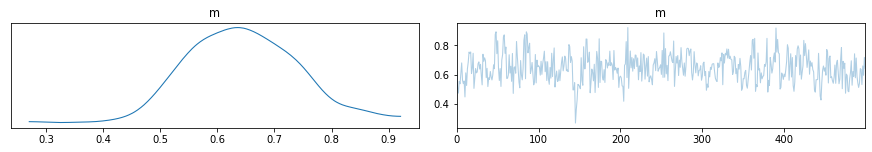

In [31]:
az.plot_trace(data, var_names=('m'), filter_vars="like", coords=coords)

In [32]:
data.posterior.chain

<xarray.DataArray 'chain' (chain: 1)>
array([0])
Coordinates:
  * chain    (chain) int64 0